In [1]:
device = "cuda:0"

### Helper

In [9]:
import os
import sys

# to import functions from `patching_utils.py` and `plotly_utils.py`,
# we need to add the repository directory to the system path.
current_dir = os.path.dirname(os.getcwd())
print(current_dir)
if current_dir not in sys.path:
    sys.path.append(current_dir)

/home/qinyuan/function-induction


In [10]:
import torch as t
from torch import Tensor
import torch.nn.functional as F

from transformer_lens import HookedTransformer, patching, ActivationCache, utils
from transformer_lens.hook_points import HookPoint

import copy
import itertools
import random

/home/qinyuan/miniconda3/envs/ts/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from data_utils import process_dataset, read_jsonl
from circuit_eval_utils import eval_circuit_batched, complete_circuit, identified_circuit, get_completeness_score

/home/qinyuan/function-induction


In [5]:
model_name = "google/gemma-2-9b"
model = HookedTransformer.from_pretrained(model_name, device=device)
model.set_ungroup_grouped_query_attention(True)

Loading checkpoint shards: 100%|██████████| 8/8 [00:00<00:00, 131.39it/s]


Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [6]:
setting, nmax, offset, n_icl_examples = "setting1", 9, 1, 16
filename = f"../data/addition/{setting}/addition_nmax{nmax}_offset{offset}.jsonl"
data = read_jsonl(filename)
processed_data = process_dataset(data, n_icl_examples=n_icl_examples, offset=offset)

### Faithfulness

In [7]:
circuit = identified_circuit(n_shot=16)
data = processed_data
patched_logits_diff, normal_logits_diff, contrast_logits_diff = eval_circuit_batched(model, data, circuit, batch_size=1)

r = (patched_logits_diff - normal_logits_diff) / (contrast_logits_diff - normal_logits_diff)
print("Faithfulness metric: {}".format(r.item()))
print(patched_logits_diff.item() / 100, contrast_logits_diff.item()/ 100, normal_logits_diff.item()/ 100)

batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]

Faithfulness metric: 0.784003734588623
0.558412094116211 -1.2620720672607422 7.166240234375


### Completeness

#### Case 1: Random sets

In [8]:
# Case 1
C = identified_circuit(n_shot=16)
random.seed(202505)

all_heads = list(itertools.chain.from_iterable(C["head_circuit"].values()))

def random_subsets(l, n_seq, n_item):
    ret = []
    for i in range(n_seq):
        random.shuffle(l)
        ret.append(l[:n_item]) 
    return ret

sampled_heads = random_subsets(all_heads, n_seq=20, n_item=5)
print(sampled_heads)

[[(36, 7), (38, 6), (40, 11), (25, 13), (38, 9)], [(32, 6), (38, 9), (39, 7), (41, 4), (38, 6)], [(38, 9), (35, 14), (40, 11), (39, 12), (36, 7)], [(39, 12), (40, 12), (35, 9), (40, 11), (31, 5)], [(38, 9), (35, 9), (35, 14), (41, 4), (40, 11)], [(32, 1), (38, 7), (40, 12), (29, 5), (39, 7)], [(32, 6), (40, 11), (39, 7), (35, 9), (38, 6)], [(32, 1), (31, 4), (39, 12), (32, 6), (25, 13)], [(38, 6), (39, 12), (38, 9), (40, 12), (39, 7)], [(38, 6), (29, 5), (32, 1), (40, 11), (31, 5)], [(38, 6), (25, 13), (41, 5), (32, 6), (41, 4)], [(39, 12), (31, 5), (32, 6), (35, 9), (29, 5)], [(36, 7), (35, 14), (25, 13), (31, 5), (32, 1)], [(41, 4), (39, 12), (32, 6), (32, 1), (29, 5)], [(40, 12), (32, 6), (38, 7), (32, 1), (40, 11)], [(41, 5), (32, 1), (38, 6), (40, 11), (25, 13)], [(32, 6), (35, 9), (40, 12), (31, 5), (29, 5)], [(40, 11), (35, 14), (41, 5), (32, 1), (36, 7)], [(39, 12), (36, 7), (40, 11), (25, 13), (38, 6)], [(41, 4), (38, 9), (39, 12), (31, 4), (32, 6)]]


In [9]:
C = identified_circuit(n_shot=16)
M = complete_circuit(n_shot=16)

completeness_case1_result = {}
for i, heads in enumerate(sampled_heads):
    score_A, score_B = get_completeness_score(model, data, C=C, K=heads, M=M, batch_size=1)
    print("Case {}:".format(i), score_A, score_B, abs(score_A-score_B)) # score A: C/K; score B: M/K
    completeness_case1_result[i] = [heads, score_A, score_B, abs(score_A-score_B)]

batch: 100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


Case 0: 2.547141571044922 -0.07345759391784668 2.6205991649627687


batch: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


Case 1: 2.3386410522460936 -1.0755357360839843 3.414176788330078


batch: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


Case 2: 2.699019470214844 -0.12439414978027344 2.8234136199951174


batch: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


Case 3: 1.8515440368652343 -0.8208830261230469 2.672427062988281


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 4: -0.04411533832550049 -2.5036575317382814 2.459542193412781


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 5: 4.948926391601563 1.4127159118652344 3.5362104797363285


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 6: 4.605752563476562 1.2698356628417968 3.335916900634765


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 7: 3.0107733154296876 -0.19352298736572265 3.2042963027954103


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 8: 5.4933233642578125 1.118897933959961 4.374425430297851


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 9: 1.9841629028320313 -1.0663238525390626 3.050486755371094


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 10: -1.290277099609375 -3.0240234375 1.7337463378906248


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 11: 3.484246826171875 -0.053753342628479 3.538000168800354


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 12: 3.3741815185546873 0.6223561096191407 2.7518254089355465


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 13: 0.40628971099853517 -2.59814697265625 3.0044366836547853


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 14: 2.351753692626953 -0.17903564453125 2.530789337158203


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 15: 2.30637451171875 -0.6414163208007813 2.947790832519531


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 16: 1.9457846069335938 -0.6443323516845703 2.590116958618164


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 17: 2.9664797973632813 0.02606790542602539 2.9404118919372557


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Case 18: 3.638946533203125 0.16908353805541992 3.469862995147705


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]

Case 19: 0.4222685241699219 -2.414336700439453 2.836605224609375


In [10]:
print(completeness_case1_result)

{0: [[(36, 7), (38, 6), (40, 11), (25, 13), (38, 9)], 2.547141571044922, -0.07345759391784668, 2.6205991649627687], 1: [[(32, 6), (38, 9), (39, 7), (41, 4), (38, 6)], 2.3386410522460936, -1.0755357360839843, 3.414176788330078], 2: [[(38, 9), (35, 14), (40, 11), (39, 12), (36, 7)], 2.699019470214844, -0.12439414978027344, 2.8234136199951174], 3: [[(39, 12), (40, 12), (35, 9), (40, 11), (31, 5)], 1.8515440368652343, -0.8208830261230469, 2.672427062988281], 4: [[(38, 9), (35, 9), (35, 14), (41, 4), (40, 11)], -0.04411533832550049, -2.5036575317382814, 2.459542193412781], 5: [[(32, 1), (38, 7), (40, 12), (29, 5), (39, 7)], 4.948926391601563, 1.4127159118652344, 3.5362104797363285], 6: [[(32, 6), (40, 11), (39, 7), (35, 9), (38, 6)], 4.605752563476562, 1.2698356628417968, 3.335916900634765], 7: [[(32, 1), (31, 4), (39, 12), (32, 6), (25, 13)], 3.0107733154296876, -0.19352298736572265, 3.2042963027954103], 8: [[(38, 6), (39, 12), (38, 9), (40, 12), (39, 7)], 5.4933233642578125, 1.11889793395

In [3]:
completeness_case1_result = {0: [[(36, 7), (38, 6), (40, 11), (25, 13), (38, 9)], 2.547141571044922, -0.07345759391784668, 2.6205991649627687], 1: [[(32, 6), (38, 9), (39, 7), (41, 4), (38, 6)], 2.3386410522460936, -1.0755357360839843, 3.414176788330078], 2: [[(38, 9), (35, 14), (40, 11), (39, 12), (36, 7)], 2.699019470214844, -0.12439414978027344, 2.8234136199951174], 3: [[(39, 12), (40, 12), (35, 9), (40, 11), (31, 5)], 1.8515440368652343, -0.8208830261230469, 2.672427062988281], 4: [[(38, 9), (35, 9), (35, 14), (41, 4), (40, 11)], -0.04411533832550049, -2.5036575317382814, 2.459542193412781], 5: [[(32, 1), (38, 7), (40, 12), (29, 5), (39, 7)], 4.948926391601563, 1.4127159118652344, 3.5362104797363285], 6: [[(32, 6), (40, 11), (39, 7), (35, 9), (38, 6)], 4.605752563476562, 1.2698356628417968, 3.335916900634765], 7: [[(32, 1), (31, 4), (39, 12), (32, 6), (25, 13)], 3.0107733154296876, -0.19352298736572265, 3.2042963027954103], 8: [[(38, 6), (39, 12), (38, 9), (40, 12), (39, 7)], 5.4933233642578125, 1.118897933959961, 4.374425430297851], 9: [[(38, 6), (29, 5), (32, 1), (40, 11), (31, 5)], 1.9841629028320313, -1.0663238525390626, 3.050486755371094], 10: [[(38, 6), (25, 13), (41, 5), (32, 6), (41, 4)], -1.290277099609375, -3.0240234375, 1.7337463378906248], 11: [[(39, 12), (31, 5), (32, 6), (35, 9), (29, 5)], 3.484246826171875, -0.053753342628479, 3.538000168800354], 12: [[(36, 7), (35, 14), (25, 13), (31, 5), (32, 1)], 3.3741815185546873, 0.6223561096191407, 2.7518254089355465], 13: [[(41, 4), (39, 12), (32, 6), (32, 1), (29, 5)], 0.40628971099853517, -2.59814697265625, 3.0044366836547853], 14: [[(40, 12), (32, 6), (38, 7), (32, 1), (40, 11)], 2.351753692626953, -0.17903564453125, 2.530789337158203], 15: [[(41, 5), (32, 1), (38, 6), (40, 11), (25, 13)], 2.30637451171875, -0.6414163208007813, 2.947790832519531], 16: [[(32, 6), (35, 9), (40, 12), (31, 5), (29, 5)], 1.9457846069335938, -0.6443323516845703, 2.590116958618164], 17: [[(40, 11), (35, 14), (41, 5), (32, 1), (36, 7)], 2.9664797973632813, 0.02606790542602539, 2.9404118919372557], 18: [[(39, 12), (36, 7), (40, 11), (25, 13), (38, 6)], 3.638946533203125, 0.16908353805541992, 3.469862995147705], 19: [[(41, 4), (38, 9), (39, 12), (31, 4), (32, 6)], 0.4222685241699219, -2.414336700439453, 2.836605224609375]}

#### Case 2: Knock out a group

In [9]:
C = identified_circuit(n_shot=16)
M = complete_circuit(n_shot=16)
data = processed_data

completeness_case2_result = {}

score_A, score_B = get_completeness_score(model, data, C=C, K=[], M=M, batch_size=1)
print("empty set", [])
print(score_A, score_B, abs(score_A-score_B))
completeness_case2_result["empty_set"] = [score_A, score_B, abs(score_A-score_B)]

for key, value in C["head_circuit"].items():
    score_A, score_B = get_completeness_score(model, data, C=C, K=value, M=M, batch_size=1)
    print(key, value)
    print(score_A, score_B, abs(score_A-score_B))
    completeness_case2_result[key] = [score_A, score_B, abs(score_A-score_B)]


batch: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


empty set []
0.558412094116211 -1.2620720672607422 1.8204841613769531


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


function_induction [(39, 12), (39, 7), (36, 7), (32, 6), (32, 1), (25, 13)]
7.170979614257813 3.2567413330078123 3.9142382812500003


batch: 100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


prev_token [(38, 9), (38, 6), (38, 7), (35, 9), (35, 14), (31, 5), (31, 4), (29, 5)]
7.213325805664063 3.01134765625 4.201978149414063


batch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]

consolidate [(41, 5), (41, 4), (40, 12), (40, 11)]
-4.1570166015625 -3.5649850463867185 0.5920315551757813


In [10]:
print(completeness_case2_result)

{'empty_set': [0.558412094116211, -1.2620720672607422, 1.8204841613769531], 'function_induction': [7.170979614257813, 3.2567413330078123, 3.9142382812500003], 'prev_token': [7.213325805664063, 3.01134765625, 4.201978149414063], 'consolidate': [-4.1570166015625, -3.5649850463867185, 0.5920315551757813]}


In [2]:
completeness_case2_result = {'empty_set': [0.558412094116211, -1.2620720672607422, 1.8204841613769531], 'function_induction': [7.170979614257813, 3.2567413330078123, 3.9142382812500003], 'prev_token': [7.213325805664063, 3.01134765625, 4.201978149414063], 'consolidate': [-4.1570166015625, -3.5649850463867185, 0.5920315551757813]}

#### Case 3: Greedy search sets
* See `circuit_eval_offline.py`

In [4]:
completeness_case3_result = {0: [[(39, 12), (39, 7), (31, 5), (40, 11), (31, 4)], 6.1543994140625, 1.5049789428710938, 4.649420471191406], 1: [[(31, 4), (39, 7), (39, 12), (41, 4), (31, 5)], 5.753678588867188, 0.5158133697509766, 5.237865219116211], 2: [[(35, 9), (32, 1), (39, 12), (39, 7), (36, 7)], 7.096732177734375, 2.828329772949219, 4.2684024047851565], 3: [[(38, 7), (39, 12), (41, 4), (35, 9), (31, 5)], 4.4522091674804685, -0.8099837493896485, 5.2621929168701165], 4: [[(39, 7), (38, 6), (35, 9), (39, 12), (41, 4)], 5.814006958007813, 1.0915948486328124, 4.722412109375], 5: [[(38, 7), (35, 9), (41, 4), (39, 12), (38, 6)], 5.392804565429688, -0.08559731483459472, 5.478401880264283], 6: [[(39, 12), (35, 9), (38, 6), (41, 4), (29, 5)], 2.6649325561523436, -1.9233621215820313, 4.588294677734375], 7: [[(38, 7), (39, 7), (40, 11), (32, 1), (41, 4)], 3.7288858032226564, -0.9970648193359375, 4.725950622558594], 8: [[(38, 7), (32, 1), (39, 7), (38, 6), (40, 11)], 5.355679321289062, 0.8571967315673829, 4.49848258972168], 9: [[(39, 12), (32, 1), (35, 9), (38, 6), (31, 4)], 5.420776977539062, 0.8169365692138671, 4.603840408325195]}

### Minimality

In [13]:
def get_minimality_circuits(C, K, v):
  """return A: C\\K and B: M\\K as defined in sec 4.1. C: current circuit, K: heads to remove, M: full model circuit"""
  circuit_A, circuit_B = copy.deepcopy(C), copy.deepcopy(C)
  for key in C["head_circuit"].keys():
    circuit_A["head_circuit"][key] = list(set(C["head_circuit"][key]).difference(K))
    circuit_B["head_circuit"][key] = list(set(C["head_circuit"][key]).difference(K+[v]))
  return circuit_A, circuit_B

def get_minimality_score(model, data, C, K, v):
  circuit_A, circuit_B = get_minimality_circuits(C, K, v)
  patched_logits_diff_A, _, _ = eval_circuit_batched(model, data, circuit_A, batch_size=1)
  patched_logits_diff_B, _, _ = eval_circuit_batched(model, data, circuit_B, batch_size=1)
  N = len(data)
  return patched_logits_diff_A.item() / N, patched_logits_diff_B.item() / N

In [14]:
minimality_sets = {
    # fi heads
    (32, 6): [(41, 4), (39, 7), (39, 12), (40,11), (40,12)],
    (25, 13): [(41, 4), (40,11), (40,12), (38, 7), (39, 7)], 
    # pt heads
    (38, 9): [(41, 4), (40,11), (40,12), (38, 6), (38, 7)],
    (35, 14): [(41, 4), (40,11), (40,12), (38, 6), (38, 7), (38, 9)], 
    (31, 5): [(39, 7), (31, 4), (29,5), (41, 4), (40,11), (40,12)], 
    (29, 5): [(39, 7), (31, 4)], 
}

In [15]:
C = identified_circuit(n_shot=16)

minimality_result = {}

for k, v in C["head_circuit"].items():
    minimality_result[k] = {}
    for head in v:
        K = minimality_sets.get(head, [])
        score_A, score_B = get_minimality_score(model, data, C, K, head)
        print("{}: {:.4f}".format(head, abs(score_A-score_B)))
        minimality_result[k][head] = (score_A, score_B, abs(score_A-score_B))


batch: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


(39, 12): 0.8503


batch: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


(39, 7): 2.5012


batch: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


(36, 7): 1.4951


batch: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


(32, 6): 0.2989


batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


(32, 1): 1.0493


batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


(25, 13): 0.3296


batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


(38, 9): 0.4771


batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


(38, 6): 0.5096


batch: 100%|██████████| 100/100 [01:16<00:00,  1.32it/s]


(38, 7): 1.7161


batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


(35, 9): 1.2478


batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


(35, 14): 0.2370


batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


(31, 5): 0.5863


batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


(31, 4): 0.7332


batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


(29, 5): 0.2425


batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


(41, 5): 0.2011


batch: 100%|██████████| 100/100 [01:16<00:00,  1.32it/s]


(41, 4): 2.9604


batch: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


(40, 12): 0.8565


batch: 100%|██████████| 100/100 [01:16<00:00,  1.32it/s]

(40, 11): 0.3565


In [16]:
print(minimality_result)

{'function_induction': {(39, 12): (0.558412094116211, 1.4086929321289063, 0.8502808380126954), (39, 7): (0.558412094116211, 3.059565124511719, 2.501153030395508), (36, 7): (0.558412094116211, 2.053508758544922, 1.495096664428711), (32, 6): (4.2445242309570315, 4.54339111328125, 0.29886688232421843), (32, 1): (0.558412094116211, 1.6077403259277343, 1.0493282318115233), (25, 13): (2.0369418334960936, 2.366573944091797, 0.3296321105957034)}, 'prev_token': {(38, 9): (1.1680657196044921, 1.6451393127441407, 0.4770735931396486), (38, 6): (0.558412094116211, 1.0679905700683594, 0.5095784759521484), (38, 7): (0.558412094116211, 2.274483489990234, 1.7160713958740232), (35, 9): (0.558412094116211, 1.8062324523925781, 1.2478203582763672), (35, 14): (1.6451393127441407, 1.882119140625, 0.23697982788085925), (31, 5): (1.3233534240722655, 1.9096836853027344, 0.5863302612304688), (31, 4): (0.558412094116211, 1.2916307067871093, 0.7332186126708984), (29, 5): (4.0847625732421875, 4.327237854003906, 0.2

In [5]:
# numbers from faithfulness results
contrast_logits_diff = -1.2620720672607422
normal_logits_diff = 7.166240234375
minimality_result = {'function_induction': {(39, 12): (0.558412094116211, 1.4086929321289063, 0.8502808380126954), (39, 7): (0.558412094116211, 3.059565124511719, 2.501153030395508), (36, 7): (0.558412094116211, 2.053508758544922, 1.495096664428711), (32, 6): (4.2445242309570315, 4.54339111328125, 0.29886688232421843), (32, 1): (0.558412094116211, 1.6077403259277343, 1.0493282318115233), (25, 13): (2.0369418334960936, 2.366573944091797, 0.3296321105957034)}, 'prev_token': {(38, 9): (1.1680657196044921, 1.6451393127441407, 0.4770735931396486), (38, 6): (0.558412094116211, 1.0679905700683594, 0.5095784759521484), (38, 7): (0.558412094116211, 2.274483489990234, 1.7160713958740232), (35, 9): (0.558412094116211, 1.8062324523925781, 1.2478203582763672), (35, 14): (1.6451393127441407, 1.882119140625, 0.23697982788085925), (31, 5): (1.3233534240722655, 1.9096836853027344, 0.5863302612304688), (31, 4): (0.558412094116211, 1.2916307067871093, 0.7332186126708984), (29, 5): (4.0847625732421875, 4.327237854003906, 0.24247528076171854)}, 'consolidate': {(41, 5): (0.558412094116211, 0.7595432281494141, 0.20113113403320315), (41, 4): (0.558412094116211, -2.4019805908203127, 2.9603926849365236), (40, 12): (0.558412094116211, -0.2980510711669922, 0.8564631652832031), (40, 11): (0.558412094116211, 0.20192384719848633, 0.3564882469177246)}}

### Plotting

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.sans-serif'] = 'DejaVu Serif' 

In [12]:
# Process results for plotting

# Completeness
case3 = {}
for k, v in completeness_case3_result.items():
    case3[k] = [v[1], v[2]]
case1 = {}
for k, v in completeness_case1_result.items():
    case1[k] = [v[1], v[2]]

case2 = completeness_case2_result

# Minimality
C = identified_circuit(n_shot=16)

denominator = -1 * (contrast_logits_diff - normal_logits_diff)
scores_for_plot = {}
for k, v in C["head_circuit"].items():
    scores_for_plot[k] = {}
    for head in v:
        scores_for_plot[k][head] = minimality_result[k][head][2] / denominator
sorted_data = {}
for category, entries in scores_for_plot.items():
    sorted_items = sorted(entries.items(), key=lambda x: -x[1])  # sort by negative of value to get decreasing order
    sorted_data[category] = sorted_items    

In [13]:
# Color and marker definitions
color_map = {
    'consolidate': '#7030a0',
    'function_induction': '#0070c0', 
    'prev_token': '#4da72e', 
    'empty_set': '#909090',
}

marker_map = {
    'function_induction': 'o',
    'prev_token': 'o',
    'consolidate': 'o',
    'empty_set': 'o',
}

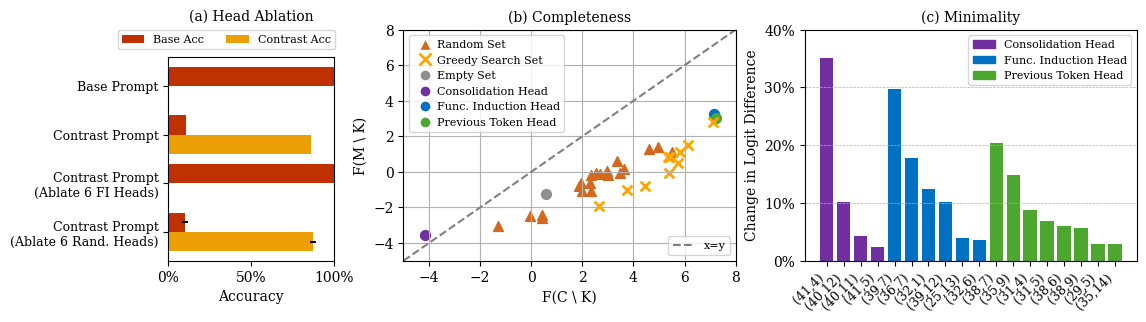

In [14]:
# Plotting
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12.5, 3), width_ratios=[2.5, 5, 5])

plt.subplots_adjust(wspace=0.25)  # adjust spacing

## head abltion
ax0_result = {'base': (1.0, 0.0),
    'contrast': (0.11, 0.86),
    'contrast_fih': (1.0, 0.0),
    'contrast_rh': (0.1, 0.8720000000000001),
    'contrast_rh_std': (0.01673320053068151, 0.019390719429665335)
}

y1 = [ax0_result[key][0] for key in ["base", "contrast", "contrast_fih", "contrast_rh"]]
y2 = [ax0_result[key][1] for key in ["base", "contrast", "contrast_fih", "contrast_rh"]]

std1 = [0, 0, 0] + [ax0_result["contrast_rh_std"][0]]
std2 = [0, 0, 0] + [ax0_result["contrast_rh_std"][1]]

labels = ["Base Prompt", "Contrast Prompt", "Contrast Prompt\n(Ablate 6 FI Heads)", "Contrast Prompt\n(Ablate 6 Rand. Heads)"]

x = np.arange(len(y1))  # the label locations
width = 0.4  # the width of the bars

# fig, ax = plt.subplots(figsize=(4, 3.5))
rects2 = ax0.barh(x + width/2, y1[::-1], width, xerr=std1[::-1], label='Base Acc', color="#bf3100")
rects1 = ax0.barh(x - width/2, y2[::-1], width, xerr=std2[::-1], label='Contrast Acc', color="#ec9f05")

# Add labels, title, and legend
ax0.set_xlabel("Accuracy")
ax0.set_yticks(x)
ax0.set_yticklabels(labels[::-1], fontsize=9)
ax0.set_xticks([0, 0.5, 1.0])
ax0.set_xticklabels(["0%", "50%", "100%"])
ax0.legend(bbox_to_anchor=(0.35, 1.16), loc='upper center', ncol=2, fontsize=8)
# ax0.set_ylim(-0.5, 4.5)
ax0.set_xlim(0, 1)

ax0.set_title("(a) Head Ablation", y=1.14, fontsize=10)

pos = ax0.get_position()
ax0.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.88])  # move up + make shorter

# Case 1 points (random set)
for idx, (x, y) in case1.items():
    ax1.scatter(x, y, color='chocolate', marker='^', s=50)  # Green left triangle

# Case 2 points (remaining dots)
for category, (x, y, _) in case2.items():
    ax1.scatter(x, y, color=color_map[category], marker=marker_map[category], s=50)

# Case 3 points (greedy search set)
for idx, (x, y) in case3.items():
    ax1.scatter(x, y, color='orange', marker='x', s=50, linewidths=2)

# Dashed diagonal line x=y
lim = max(
    max([x for x, y in case1.values()]),
    max([x for x, y, _ in case2.values()]),
    max([x for x, y in case3.values()])
) + 1
ax1.plot([-5, 8], [-5, 8], linestyle='--', color='gray', label='x=y')

# Labels and grid
ax1.set_title("(b) Completeness", fontsize=10)
ax1.set_xlabel("F(C \\ K)")
ax1.set_ylabel("F(M \\ K)")
ax1.grid(True)
ax1.set_xlim(-5, 8)
ax1.set_ylim(-5, 8)

# Custom legend
custom_legend = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='chocolate', label='Random Set', markersize=8),
    Line2D([0], [0], marker='x', color='w', markeredgecolor='orange', label='Greedy Search Set', markersize=8, markeredgewidth=2),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['empty_set'], label='Empty Set', markersize=8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['consolidate'], label='Consolidation Head', markersize=8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['function_induction'], label='Func. Induction Head', markersize=8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['prev_token'], label='Previous Token Head', markersize=8),
    # Line2D([0], [0], linestyle='--', color='gray', label='x=y')
]
first_legend = ax1.legend(handles=custom_legend, handletextpad=0.1, fontsize=8)
ax1.legend(handles=[Line2D([0], [0], linestyle='--', color='gray', label='x=y')], loc='lower right', fontsize=8)
ax1.add_artist(first_legend)

x_labels = []
x_ticks = []
heights = []
bar_colors = []

i = 0
for category in ["consolidate", "function_induction", "prev_token"]:
    sorted_entries = sorted_data[category]
    for (layer, head), val in sorted_entries:
        x_labels.append(f"({layer},{head})")
        heights.append(val * 100)  # Convert to positive percentage
        bar_colors.append(color_map[category])
        x_ticks.append(i)
        i += 1

# Plotting
ax2.bar(x_ticks, heights, color=bar_colors)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_labels, rotation=45, fontsize=9, ha='right')
ax2.set_yticks([0,10,20,30,40])
ax2.set_yticklabels(["0%", "10%", "20%", "30%", "40%"])
ax2.set_ylabel("Change in Logit Difference")
# ax2.set_xlabel("Attention Head")
ax2.set_title("(c) Minimality", fontsize=10)
ax2.set_ylim(0, 40)
ax2.grid(True, axis='y', linestyle='--', linewidth=0.5)

# Legend
handles = [plt.Rectangle((0,0),1,1,color=color_map[category]) for category in ["consolidate", "function_induction", "prev_token"]]
labels = ['Consolidation Head', 'Func. Induction Head', 'Previous Token Head']
ax2.legend(handles, labels, ncol=1, fontsize=8)


# plt.savefig("figures/circuit_eval.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
# plt.tight_layout()
plt.show()


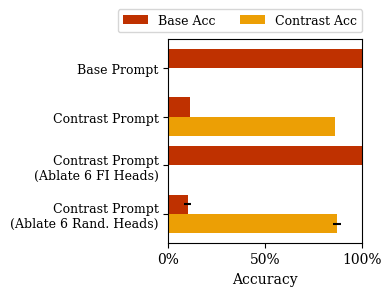

In [30]:
fig1, ax0 = plt.subplots(figsize=(2.5, 3))  # separate figure

ax0_result = {'base': (1.0, 0.0),
    'contrast': (0.11, 0.86),
    'contrast_fih': (1.0, 0.0),
    'contrast_rh': (0.1, 0.8720000000000001),
    'contrast_rh_std': (0.01673320053068151, 0.019390719429665335)
}

y1 = [ax0_result[key][0] for key in ["base", "contrast", "contrast_fih", "contrast_rh"]]
y2 = [ax0_result[key][1] for key in ["base", "contrast", "contrast_fih", "contrast_rh"]]

std1 = [0, 0, 0] + [ax0_result["contrast_rh_std"][0]]
std2 = [0, 0, 0] + [ax0_result["contrast_rh_std"][1]]

labels = ["Base Prompt", "Contrast Prompt", "Contrast Prompt\n(Ablate 6 FI Heads)", "Contrast Prompt\n(Ablate 6 Rand. Heads)"]


x = np.arange(len(y1))  # the label locations
width = 0.4  # the width of the bars

# fig, ax = plt.subplots(figsize=(4, 3.5))
rects2 = ax0.barh(x + width/2, y1[::-1], width, xerr=std1[::-1], label='Base Acc', color="#bf3100")
rects1 = ax0.barh(x - width/2, y2[::-1], width, xerr=std2[::-1], label='Contrast Acc', color="#ec9f05")

# Add labels, title, and legend
ax0.set_xlabel("Accuracy")
ax0.set_yticks(x)
ax0.set_yticklabels(labels[::-1], fontsize=9)
ax0.set_xticks([0, 0.5, 1.0])
ax0.set_xticklabels(["0%", "50%", "100%"])
ax0.legend(bbox_to_anchor=(0.37, 1.18), loc='upper center', ncol=2, fontsize=9)
# ax0.set_ylim(-0.5, 4.5)
ax0.set_xlim(0, 1)

# ax0.set_title("(a) Head Ablation", y=1.14, fontsize=10)

pos = ax0.get_position()
ax0.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.88])  # move up + make shorter

# Case 1 poin
plt.savefig("figures/circuit_eval_part1.pdf", dpi=300, bbox_inches='tight')
plt.show()


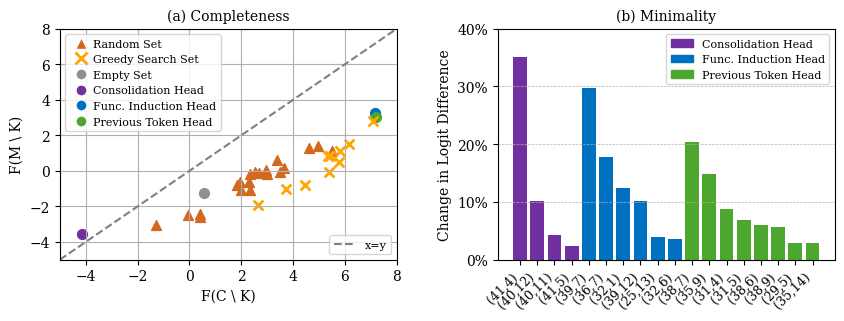

In [33]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
plt.subplots_adjust(wspace=0.3)

# Case 1 points (random set)
for idx, (x, y) in case1.items():
    ax1.scatter(x, y, color='chocolate', marker='^', s=50)  # Green left triangle

# Case 2 points (remaining dots)
for category, (x, y, _) in case2.items():
    ax1.scatter(x, y, color=color_map[category], marker=marker_map[category], s=50)

# Case 3 points (greedy search set)
for idx, (x, y) in case3.items():
    ax1.scatter(x, y, color='orange', marker='x', s=50, linewidths=2)

# Dashed diagonal line x=y
lim = max(
    max([x for x, y in case1.values()]),
    max([x for x, y, _ in case2.values()]),
    max([x for x, y in case3.values()])
) + 1
ax1.plot([-5, 8], [-5, 8], linestyle='--', color='gray', label='x=y')

# Labels and grid
ax1.set_title("(a) Completeness", fontsize=10)
ax1.set_xlabel("F(C \\ K)")
ax1.set_ylabel("F(M \\ K)")
ax1.grid(True)
ax1.set_xlim(-5, 8)
ax1.set_ylim(-5, 8)

# Custom legend
custom_legend = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='chocolate', label='Random Set', markersize=8),
    Line2D([0], [0], marker='x', color='w', markeredgecolor='orange', label='Greedy Search Set', markersize=8, markeredgewidth=2),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['empty_set'], label='Empty Set', markersize=8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['consolidate'], label='Consolidation Head', markersize=8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['function_induction'], label='Func. Induction Head', markersize=8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['prev_token'], label='Previous Token Head', markersize=8),
    # Line2D([0], [0], linestyle='--', color='gray', label='x=y')
]
first_legend = ax1.legend(handles=custom_legend, handletextpad=0.1, fontsize=8)
ax1.legend(handles=[Line2D([0], [0], linestyle='--', color='gray', label='x=y')], loc='lower right', fontsize=8)
ax1.add_artist(first_legend)

x_labels = []
x_ticks = []
heights = []
bar_colors = []

i = 0
for category in ["consolidate", "function_induction", "prev_token"]:
    sorted_entries = sorted_data[category]
    for (layer, head), val in sorted_entries:
        x_labels.append(f"({layer},{head})")
        heights.append(val * 100)  # Convert to positive percentage
        bar_colors.append(color_map[category])
        x_ticks.append(i)
        i += 1

# Plotting
ax2.bar(x_ticks, heights, color=bar_colors)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_labels, rotation=45, fontsize=9, ha='right')
ax2.set_yticks([0,10,20,30,40])
ax2.set_yticklabels(["0%", "10%", "20%", "30%", "40%"])
ax2.set_ylabel("Change in Logit Difference")
# ax2.set_xlabel("Attention Head")
ax2.set_title("(b) Minimality", fontsize=10)
ax2.set_ylim(0, 40)
ax2.grid(True, axis='y', linestyle='--', linewidth=0.5)

# Legend
handles = [plt.Rectangle((0,0),1,1,color=color_map[category]) for category in ["consolidate", "function_induction", "prev_token"]]
labels = ['Consolidation Head', 'Func. Induction Head', 'Previous Token Head']
ax2.legend(handles, labels, ncol=1, fontsize=8)


plt.savefig("figures/circuit_eval_part2.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
# plt.tight_layout()
plt.show()